In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from models.model_config_hyperparameter_sensitivity import *


In [2]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [3]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [4]:
def get_best_student_ensamble(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

In [5]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [6]:
from models.model_config_GSP import *

analysis_type="model_assessment"
dataset_split="val"
dataset = "gender_data"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_4_args,
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_4
[[0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2]]
[[0.968888888888889, 5.949074074074056e-05, 1], [0.9306944444444444, 0.0004889853395061724, 3], [0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1]]
[[0.9649999999999999, 0.00012222222222222262, 2], [0.9143055555555557, 0.00022918595679012328, 1], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2]]
[[0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1]]


In [7]:
from models.model_config_GSP import *

analysis_type="model_assessment"
dataset_split="val"
dataset = "gender_data"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_4_args_2,
]

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model="gcn_student_lsp_ensamble_4_ablation", 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_4
[[0.9597222222222224, 0.0003784722222222219, 2], [0.9597222222222224, 0.0003784722222222219, 2], [0.9597222222222224, 0.0003784722222222219, 2], [0.9597222222222224, 0.0003784722222222219, 2], [0.9597222222222224, 0.0003784722222222219, 2]]
[[0.9680555555555556, 4.166666666666626e-05, 1], [0.9323611111111111, 0.0006246334876543207, 3], [0.9680555555555556, 4.166666666666626e-05, 1], [0.9680555555555556, 4.166666666666626e-05, 1], [0.9680555555555556, 4.166666666666626e-05, 1]]
[[0.9649999999999999, 0.00012222222222222262, 2], [0.9134722222222222, 0.00023844521604938257, 1], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2]]
[[0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1]]

In [8]:
from models.model_config_hyperparameter_sensitivity import *

analysis_type="model_assessment"
dataset_split="val"
dataset = "gender_data"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_4_args_1,
    gcn_student_lsp_ensamble_4_args_2,
    gcn_student_lsp_ensamble_4_args_3,
    gcn_student_lsp_ensamble_4_args_4,
    gcn_student_lsp_ensamble_4_args_5,
    gcn_student_lsp_ensamble_4_args_6
]

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model="gcn_student_lsp_ensamble_4_hyperparameter_sensitivity_2", 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_4
[[0.973888888888889, 2.5000000000000303e-05, 0], [0.9302777777777778, 0.00018125000000000064, 2], [0.9302777777777778, 0.00018125000000000064, 2], [0.9302777777777778, 0.00018125000000000064, 2], [0.9302777777777778, 0.00018125000000000064, 2]]
[[0.9905555555555559, 1.1111111111111032e-05, 1], [0.9144444444444444, 7.80092592592592e-05, 3], [0.9144444444444444, 7.80092592592592e-05, 3], [0.9905555555555559, 1.1111111111111032e-05, 1], [0.9905555555555559, 1.1111111111111032e-05, 1]]
[[0.9690277777777778, 0.0003889081790123443, 3], [0.9630555555555554, 5.138888888888925e-05, 2], [0.9630555555555554, 5.138888888888925e-05, 2], [0.9630555555555554, 5.138888888888925e-05, 2], [0.9630555555555554, 5.138888888888925e-05, 2]]
[[0.9708333333333335, 0.00021180555555555566, 0], [0.9594444444444443, 8.05555555555554e-05, 1], [0.9594444444444443, 8.05555555555554e-05, 1], [0.9594444444444443, 8.05555555555554e-05, 1], [0.9594444444444443, 8.05555555555554e-05, 1]]
gcn_stu

In [9]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(40, 5)

In [10]:
df_best_student = np.array(all_model_best_student)
df_var = []
for i in range(4):
    df_var.append(df_best_student[:, i, :, 1].flatten())
df_var = pd.DataFrame(np.array(df_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var_rep = df_var.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df_var_rep.index = index_values
df_var_rep.shape

(40, 5)

In [11]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [12]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [13]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(40, 5)

In [14]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(40, 5)

In [15]:
df_acuracy = df_acuracy.loc['max acc'].T
df_var = df_var.loc['max acc'].T
df_var = np.sqrt(df_var)

df_rep = df.loc['max acc'].T
df_var_rep = df_var_rep.loc['max acc'].T
df_var_rep = np.sqrt(df_var_rep)

In [16]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
x_ticks = ['0', '1', '2', '3', '5', '7', '9', '13.5']
# Rename the columns using the new labels
df_acuracy.columns = x_ticks
df_rep.columns = x_ticks
df_var.columns = x_ticks
df_var_rep.columns = x_ticks
# Display the modified DataFrame
df_var

,0,1,2,3,5,7,9,13.5
0,0.009602,0.009789,0.004606,0.010489,0.011591,0.011833,0.012409,0.012558
1,0.003218,0.003594,0.002141,0.003490,0.004558,0.005108,0.005348,0.006110
2,0.006678,0.006800,0.002320,0.007661,0.006158,0.006884,0.006834,0.006585
3,0.003948,0.004060,0.002809,0.004885,0.005465,0.006954,0.005511,0.006214
4,0.006378,0.006547,0.003125,0.007155,0.007465,0.008091,0.008057,0.008322


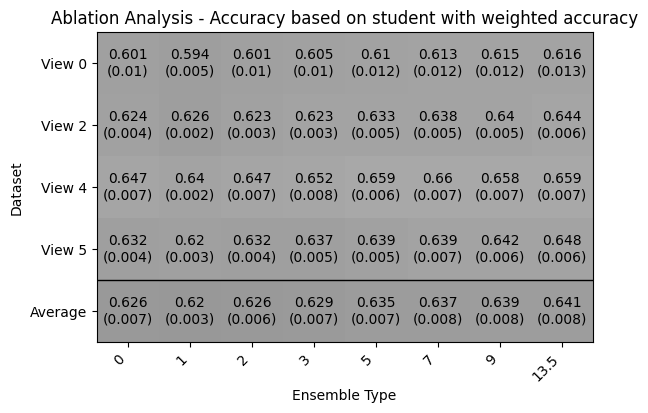

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [1, 2, 0, 3, 4, 5, 6, 7]
df_ordered = df_acuracy.iloc[:, column_order]
df_std_ordered = df_var.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['0', '1', '2', '3', '5', '7', '9', '13.5']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Analysis - Accuracy based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()


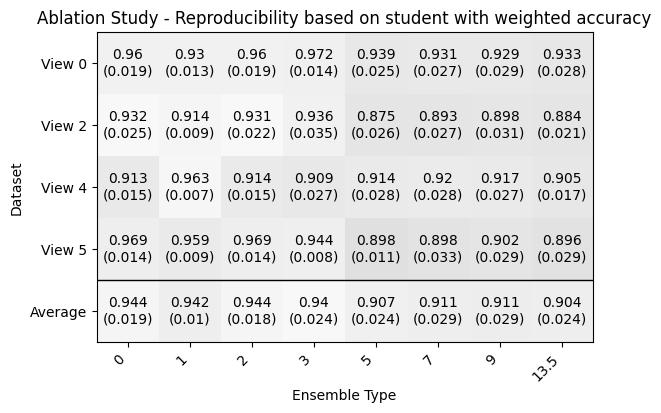

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [1, 2, 0, 3, 4, 5, 6, 7]
df_ordered = df_rep.iloc[:, column_order]
df_std_ordered = df_var_rep.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['0', '1', '2', '3', '5', '7', '9', '13.5']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Study - Reproducibility based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()

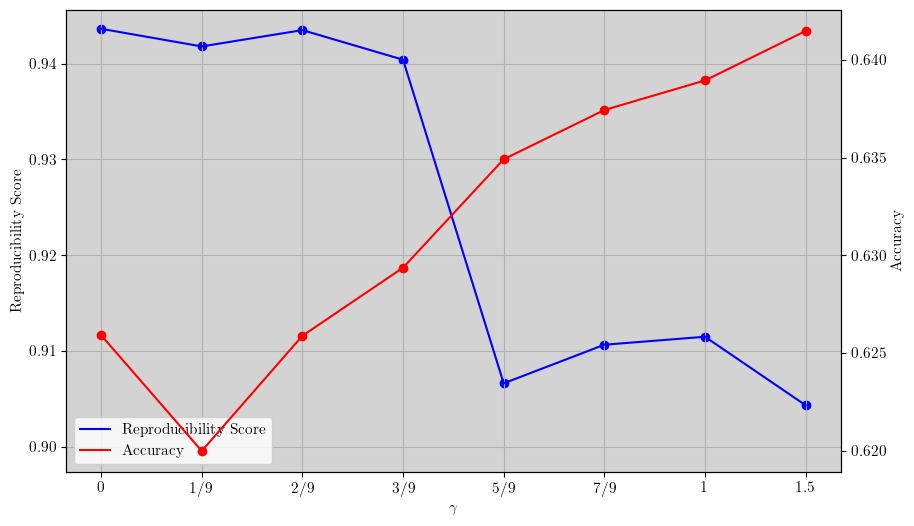

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' : 'lmodern'
}
plt.rcParams.update(params)

# Two example lists with different y-values
list1 = df_ordered.iloc[-1].tolist()
list2 = df_acuracy.iloc[:, column_order].iloc[-1].tolist()

# Create x-axis values (assuming the lists have the same length)
x = ['0','1/9', '2/9', '3/9', '5/9', '7/9', '1', '1.5']

# Create the figure and the first y-axis (left-hand side)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(x, list1, 'b-', label='Reproducibility Score')
ax1.scatter(x, list1, color='b')
ax1.set_xlabel('$$\gamma$$')
ax1.set_ylabel('Reproducibility Score')

# Create the second y-axis (right-hand side)
ax2 = ax1.twinx()
ax2.plot(x, list2, 'r-', label='Accuracy')
ax2.scatter(x, list2, color='r')
ax2.set_ylabel('Accuracy')

# Add legend
lines = ax1.get_lines() + ax2.get_lines()

# Add grid
ax1.grid(True)

# Extend the right-hand side y-axis slightly downward
ax1.set_ylim(ax1.get_ylim()[0] - 0.005, ax1.get_ylim()[1])

# Adjust legend position using bbox_to_anchor
ax1.legend(lines, [line.get_label() for line in lines], loc='lower left', bbox_to_anchor=(0, 0))

# Set grey background
ax1.set_facecolor('lightgrey')
plt.show()